In [12]:
# option, if the code doesn't work, please try this before
# pip install openpyxl

### Clean preliminary data

In [1]:
import pandas as pd
import numpy as np
#from ccxt.static_dependencies.lark.parsers.cyk import print_parse

# 1--DATA CLEANING
# region

# read file
file_path = '48_industry_portfolios.xlsx'

# create dataframes to work with
df_number_firms = pd.read_excel(file_path, sheet_name='number_firms', index_col=0) #market cap
df_firm_size = pd.read_excel(file_path, sheet_name='firm_size', index_col=0) #firm size
df_sum_BE = pd.read_excel(file_path, sheet_name='sum_BE', index_col=0) #sum of book equity
df_avg_ind_rets = pd.read_excel(file_path, sheet_name='avg_ind_rets', index_col=0) #average returns

# Convert index to string format YYYY-MM
for df in [df_number_firms, df_firm_size,df_sum_BE, df_avg_ind_rets]:
    df.index = df.index.astype(str)
    df.index = df.index.str[:4] + '-' + df.index.str[4:]

# Convert index to string format YYYY
df_sum_BE
df_sum_BE.index = df_sum_BE.index.astype(str)
df_sum_BE.index = df_sum_BE.index.str[:4]

# endregion


### Standardize factor data 

In [2]:
# 1.1--MARKET CAP
# region
df_market_cap = df_firm_size * df_number_firms
# endregion

# 1.2--BOOK TO MARKET RATIO
# region

# Expand annual Book-to-Market ratio (Sum BE / Sum ME) to monthly values
bm_monthly = []
for year in df_sum_BE.index.astype(int):
    for month in range(7, 13):  # July to December of year s
        bm_monthly.append([f"{year}-{month:02d}"] + list(df_sum_BE.loc[str(year)]))
    for month in range(1, 7):  # January to June of year s+1
        bm_monthly.append([f"{year+1}-{month:02d}"] + list(df_sum_BE.loc[str(year)]))

# Convert to DataFrame with YYYY-MM index
df_BM_monthly = pd.DataFrame(bm_monthly, columns=["Date"] + list(df_sum_BE.columns))
df_BM_monthly.set_index("Date", inplace=True)

# Ensure df_BM_monthly index matches df_market_cap index
df_BM_monthly = df_BM_monthly.loc[df_market_cap.index]
df_book_to_market = df_BM_monthly  # Element-wise multiplication

# endregion

# 1.3--MOMENTUM
# region
# Compute momentum for each industry
df_momentum = pd.DataFrame(index=df_avg_ind_rets.index, columns=df_avg_ind_rets.columns)

# Iterate over each month and industry to compute momentum
for date in df_avg_ind_rets.index:
    # Get the last 12 months' data up to the current month
    momentum_data = df_avg_ind_rets.loc[df_avg_ind_rets.index <= date].tail(12)

    # Calculate the average of the last 12 months for each industry
    df_momentum.loc[date] = momentum_data.mean(axis=0)

# endregion


In [3]:
# 2--STANDARDIZE DATA

def standardize_monthly(df):
    df_standardized = pd.DataFrame(index=df.index, columns=df.columns)

    for date in df.index:
        values = df.loc[date]
        # Exclude invalid values
        valid_values = values[(values != -99.99) & (values != -0.0)]

        mean_val = valid_values.mean()
        std_val = valid_values.std()

        # Standardize only valid values
        standardized_values = (valid_values - mean_val) / std_val

        # Store back
        df_standardized.loc[date, standardized_values.index] = standardized_values

    return df_standardized

# Apply standardization
standardized_market_cap = standardize_monthly(df_market_cap)
standardized_book_to_market = standardize_monthly(df_book_to_market)
standardized_momentum = standardize_monthly(df_momentum)

pd.set_option('display.max_columns', None)
print(standardized_momentum)


            Agric     Food      Soda      Beer      Smoke     Toys      Fun    \
1926-07 -0.079856 -0.312145       NaN -0.860347 -0.191355  0.568489 -0.066435   
1926-08 -0.187603 -0.300702       NaN  0.895636  0.012834  1.123091 -0.367305   
1926-09 -0.196809  -0.17616       NaN  1.091062  0.099348  1.558895  0.046842   
1926-10 -0.025496 -0.173918       NaN   0.95606  0.312722  1.464938 -0.051353   
1926-11  0.170833 -0.014388       NaN   1.24688  0.410077   1.38745 -0.128497   
...           ...       ...       ...       ...       ...       ...       ...   
2024-08  0.126331 -1.056603 -0.374056 -1.750122  0.845456 -1.843031  0.626719   
2024-09 -0.244267 -1.092687 -0.347186 -1.637629  0.351474 -1.437069  1.102253   
2024-10  0.313071  -1.31841 -1.077843 -2.030634  1.134644 -0.686375  1.144849   
2024-11  0.756971 -1.448882 -1.278443 -2.184167   0.99291 -0.698808  1.406331   
2024-12  0.700483  -1.16751 -0.701861 -1.639907  1.230918 -0.925912  1.878776   

            Books     Hshld

### Create tracker for Nt
This will be used to dynamically update Nt when we construct the parametric portfolio weights.

In [4]:
# Ensure same size
dfs = [standardized_market_cap, standardized_book_to_market, standardized_momentum]

# Count non-NaN values for each row in each DataFrame
non_nan_counts = [df.notna().sum(axis=1) for df in dfs]

# Compute minimum count across all DataFrames for each row
Nt_tracker = pd.DataFrame({'Nt': pd.concat(non_nan_counts, axis=1).min(axis=1)})

# Display result
print(Nt_tracker.head())

         Nt
1926-07  40
1926-08  40
1926-09  40
1926-10  40
1926-11  40


### Find the market cap portfolio (monthly)

In [5]:
# 3-- MARKET CAP PF (w_i)
df_market_cap_portfolio = df_market_cap.div(df_market_cap.sum(axis=1), axis=0) 

#Sum(.) function igores NaN values. Market cap weights are correctly normalized and calculated.


### In sample estimate of theta
For the in-sample backtest, we use the entire dataset to find $\theta^T$.


In [6]:
# 4-- IN-SAMPLE ESTIMATE OF THETA
# region

from scipy.optimize import minimize

# Define CRRA utility with risk aversion 5
def crra_utility(r, gamma=5):
    if gamma == 1:
        return np.log(1 + r)
    else:
        return ( (1 + r) ** (1 - gamma) ) / (1 - gamma)

# Objective function (minimize negative average utility)
def objective(theta, dates=None):
    theta_size, theta_bm, theta_mom = theta

    if dates is None:
        dates = df_avg_ind_rets.index[:-1]

    r_p_array = []

    # Preload DataFrames as NumPy arrays for speed
    market_cap_portfolio = df_market_cap_portfolio.loc[dates].values
    size_factors = standardized_market_cap.loc[dates].values
    bm_factors = standardized_book_to_market.loc[dates].values
    mom_factors = standardized_momentum.loc[dates].values
    avg_ind_rets = df_avg_ind_rets.loc[dates].values
    nt_values = Nt_tracker.loc[dates, "Nt"].values  # Preload valid industry counts

    for t in range(len(dates)):
        w_hat = market_cap_portfolio[t].astype(float)
        x_size = size_factors[t].astype(float)
        x_bm = bm_factors[t].astype(float)
        x_mom = mom_factors[t].astype(float)

        num_valid = max(nt_values[t], 1)  # Avoid division by zero

        tilt = (theta_size * x_size + theta_bm * x_bm + theta_mom * x_mom) / num_valid
        weights = w_hat + tilt
        weights = weights / np.nansum(weights)

        r_next = avg_ind_rets[t + 1] if t + 1 < len(dates) else np.zeros_like(weights)
        r_p = np.dot(np.nan_to_num(weights), np.nan_to_num(r_next))

        r_p_array.append(r_p)

    utilities = crra_utility(np.array(r_p_array), gamma=5)
    return -np.mean(utilities)

# Optimization with stricter stopping and lower tolerance for speed
initial_guess = [-1.220 , 3.466 , 2.000]
result = minimize(
    objective,
    initial_guess,
    method='Nelder-Mead',
    options={'maxiter': 300, 'fatol': 1e-4, 'disp': True}
)

theta_estimate = result.x
print(theta_estimate)

Optimization terminated successfully.
         Current function value: 1330.196968
         Iterations: 67
         Function evaluations: 132
[-1.21582151  3.47196596  2.10022942]


### In sample performance measures

In [7]:
import numpy as np
import pandas as pd

# Define CRRA utility (same as used for out-of-sample)
def crra_utility(r, gamma=5):
    if gamma == 1:
        return np.log(1 + r)
    else:
        return ( (1 + r) ** (1 - gamma) ) / (1 - gamma)

# In-sample estimate using the pre-defined theta values
theta_in_sample = np.array([theta_estimate[0], theta_estimate[1], theta_estimate[2]])

# Compute the portfolio returns for the entire dataset (in-sample)
def compute_in_sample_performance(theta_in_sample):
    r_p_array = []
    dates = df_avg_ind_rets.index

    # Preload data as NumPy arrays for speed
    market_cap_portfolio = df_market_cap_portfolio.loc[dates].values
    size_factors = standardized_market_cap.loc[dates].values
    bm_factors = standardized_book_to_market.loc[dates].values
    mom_factors = standardized_momentum.loc[dates].values
    avg_ind_rets = df_avg_ind_rets.loc[dates].values
    nt_values = Nt_tracker.loc[dates, "Nt"].values  # Preload valid industry counts

    # Compute monthly portfolio returns for the in-sample period
    for t in range(len(dates) - 1):  # Last date will have no next period return
        w_hat = market_cap_portfolio[t].astype(float)
        x_size = size_factors[t].astype(float)
        x_bm = bm_factors[t].astype(float)
        x_mom = mom_factors[t].astype(float)

        num_valid = max(nt_values[t], 1)  # Avoid division by zero

        # Calculate tilt and adjust portfolio weights
        tilt = (theta_in_sample[0] * x_size + theta_in_sample[1] * x_bm + theta_in_sample[2] * x_mom) / num_valid
        weights = w_hat + tilt

        # Compute next period return (r_next)
        r_next = avg_ind_rets[t + 1]  # Next period return
        r_p = np.dot(np.nan_to_num(weights), np.nan_to_num(r_next))

        r_p_array.append(r_p)

    # Compute performance metrics
    r_p_array = np.array(r_p_array)
    mean_monthly = np.mean(r_p_array)
    std_monthly = np.std(r_p_array)
    annualized_return = mean_monthly * 12
    annualized_volatility = std_monthly * np.sqrt(12)
    sharpe_ratio = annualized_return / annualized_volatility

    return annualized_return, annualized_volatility, sharpe_ratio

# Run in-sample performance calculation
annual_ret_in_sample, annual_vol_in_sample, sharpe_in_sample = compute_in_sample_performance(theta_in_sample)

print('annual return:', annual_ret_in_sample)
print('annual volatility:', annual_vol_in_sample)
print('sharpe ratio:', sharpe_in_sample)


annual return: 21.9819042914837
annual volatility: 33.43643129590976
sharpe ratio: 0.6574237572468662


### Out of sample estimate of theta & performance measures
For the out-of-sample backtest :
* We initialize $\theta^T$ with the in-sample results. 
* Then, we dynamically update $\theta^T$ by re-estimating the parameter with an increasing sample of 1 year. 
* Nt is dynamically updated every year by using the variable **Nt_counter**. 
* The parametric portfolio weights are calculated using the updated $\theta^T$ and Nt, every month for the next year.


In [8]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

def run_out_of_sample_backtest(start_year='1974-01'):
    results = []
    theta_history = []
    dates = df_avg_ind_rets.index

    for year in range(1974, int(dates[-1][:4]) + 1):  
        #print(f"Processing year: {year}")  # Track progress

        # Split in-sample (estimation) and out-of-sample (OOS) dates
        estimation_dates = dates[dates < f"{year}-01"]
        oos_dates = dates[(dates >= f"{year}-01") & (dates < f"{year+1}-01")]

        # Optimize theta using estimation data
        theta1,theta2,theta3 = theta_estimate[0], theta_estimate[1],theta_estimate[2]
        res = minimize(objective, [theta1, theta2, theta3], args=(estimation_dates,), method='Nelder-Mead')
        theta_size, theta_bm, theta_mom = res.x

        theta_history.append({'year': year, 'theta_size': theta_size, 'theta_bm': theta_bm, 'theta_mom': theta_mom})
        
        # Preload out-of-sample data as NumPy arrays
        market_cap_portfolio = df_market_cap_portfolio.loc[oos_dates].values
        size_factors = standardized_market_cap.loc[oos_dates].values
        bm_factors = standardized_book_to_market.loc[oos_dates].values
        mom_factors = standardized_momentum.loc[oos_dates].values
        avg_ind_rets = df_avg_ind_rets.loc[oos_dates].values
        nt_values = Nt_tracker.loc[oos_dates, "Nt"].values  # Get valid asset counts

        for t in range(len(oos_dates) - 1):
            date_t = oos_dates[t]
            date_t1 = oos_dates[t + 1]

            w_hat = market_cap_portfolio[t].astype(float)
            x_size = size_factors[t].astype(float)
            x_bm = bm_factors[t].astype(float)
            x_mom = mom_factors[t].astype(float)

            num_valid = max(nt_values[t], 1)  # Avoid division by zero

            # Compute tilt and adjust weights
            tilt = (theta_size * x_size + theta_bm * x_bm + theta_mom * x_mom) / num_valid
            weights = w_hat + tilt

            # Renormalize weights (Equation 16)
            weights = weights / np.nansum(weights)

            # Compute portfolio return
            r_next = avg_ind_rets[t + 1]  # Next period return
            r_p = np.dot(np.nan_to_num(weights), np.nan_to_num(r_next))

            results.append({'date': date_t1, 'portfolio_return': r_p})

    # Convert results to DataFrame
    result_df = pd.DataFrame(results).set_index('date')

    # Compute performance metrics
    mean_monthly = result_df['portfolio_return'].mean()
    std_monthly = result_df['portfolio_return'].std()
    annualized_return = mean_monthly * 12
    annualized_std = std_monthly * np.sqrt(12)
    sharpe_ratio = annualized_return / annualized_std

    return result_df, annualized_return, annualized_std, sharpe_ratio, pd.DataFrame(theta_history)

# Run out-of-sample backtest
out_sample_results, annual_ret, annual_std, sharpe, theta = run_out_of_sample_backtest()
print('historical theta', theta)
print('results', out_sample_results)
print('annual rets', annual_ret)
print('annual std', annual_std)
print('sharpe', sharpe)

historical theta     year  theta_size  theta_bm  theta_mom
0   1974   -1.230592  3.554536   2.123922
1   1975   -1.230566  3.554514   2.123917
2   1976   -1.230574  3.554520   2.123920
3   1977   -1.230574  3.554520   2.123920
4   1978   -1.230574  3.554520   2.123920
5   1979   -1.230574  3.554520   2.123920
6   1980   -1.230263  3.554340   2.123893
7   1981   -1.230263  3.554340   2.123893
8   1982   -1.228095  3.479179   2.119525
9   1983   -1.228095  3.479179   2.119525
10  1984   -1.228095  3.479179   2.119525
11  1985   -1.228093  3.479176   2.119525
12  1986   -1.228093  3.479176   2.119525
13  1987   -1.228093  3.479176   2.119525
14  1988   -1.219958  3.472636   2.109856
15  1989   -1.219958  3.472636   2.109856
16  1990   -1.219958  3.472636   2.109856
17  1991   -1.219958  3.472636   2.109856
18  1992   -1.219958  3.472636   2.109856
19  1993   -1.219958  3.472636   2.109856
20  1994   -1.219958  3.472636   2.109856
21  1995   -1.219953  3.472632   2.109851
22  1996   -1.219

### Comparison between in-sample and out-of-sample performance

In [9]:
# Percentage improvement for all performance metrics
annual_ret_improvement = ((annual_ret - annual_ret_in_sample) / annual_ret_in_sample) * 100
vol_improvement = ((annual_vol_in_sample- annual_std) / annual_vol_in_sample) * 100
sharpe_improvement = ((sharpe - sharpe_in_sample) / sharpe_in_sample) * 100

# Display results
print(f"Annual Return Improvement: {annual_ret_improvement:.2f}%")
print(f"Volatility Improvement: {vol_improvement:.2f}%")
print(f"Sharpe Ratio Improvement: {sharpe_improvement:.2f}%")

Annual Return Improvement: -13.35%
Volatility Improvement: 32.38%
Sharpe Ratio Improvement: 28.14%


### Wealth evolution

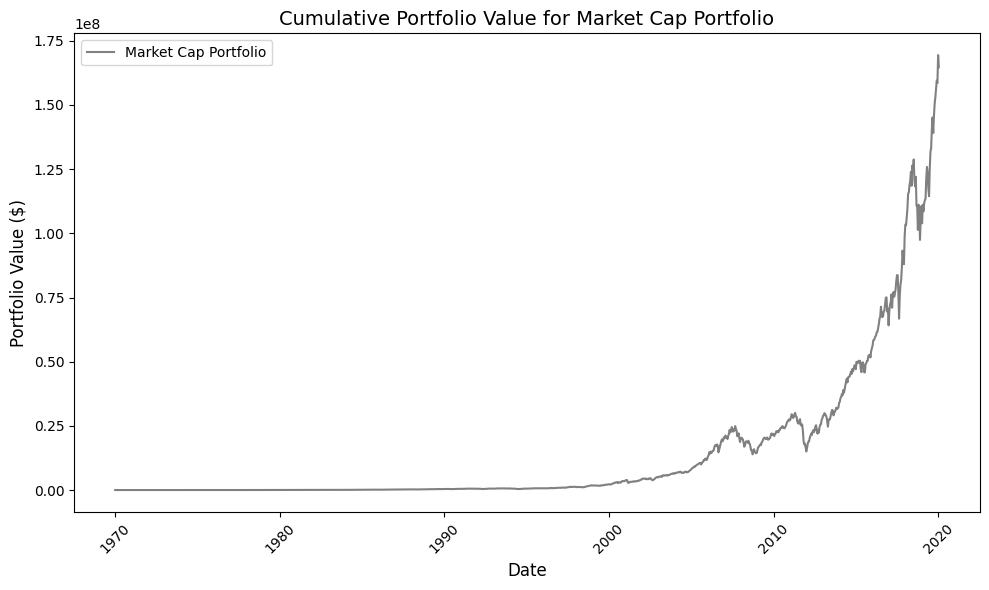

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initial portfolio value
initial_portfolio_value = 10000

# Calculate portfolio returns based on df_market_cap_portfolio and df_avg_ind_rets
portfolio_value = [initial_portfolio_value]

for i in range(1, len(df_market_cap_portfolio)):
    # Portfolio weights for the current time step (date)
    weights = df_market_cap_portfolio.iloc[i].values
    
    # Corresponding average returns for the current time step (date)
    returns = df_avg_ind_rets.iloc[i].values / 100  # Convert percentage returns to decimals
    
    # Calculate the portfolio return for the current month
    portfolio_return = np.dot(weights, returns)
    
    # Update the portfolio value
    new_portfolio_value = portfolio_value[-1] * (1 + portfolio_return)
    portfolio_value.append(new_portfolio_value)

# Convert portfolio value list into a pandas series
portfolio_value_series = pd.Series(portfolio_value, index=df_market_cap_portfolio.index)

# Plot wealth over time
plt.figure(figsize=(10, 6))
plt.plot(portfolio_value_series.index, portfolio_value_series, label='Market Cap Portfolio', color='grey')
plt.title('Cumulative Portfolio Value for Market Cap Portfolio', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend()

# tick interval setting
tick_positions = range(0, len(portfolio_value_series), int(len(portfolio_value_series) / 5)) 
#select range
tick_labels = [str(year) for year in range(1970, 2024, 10)]  
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.tight_layout()
plt.show()


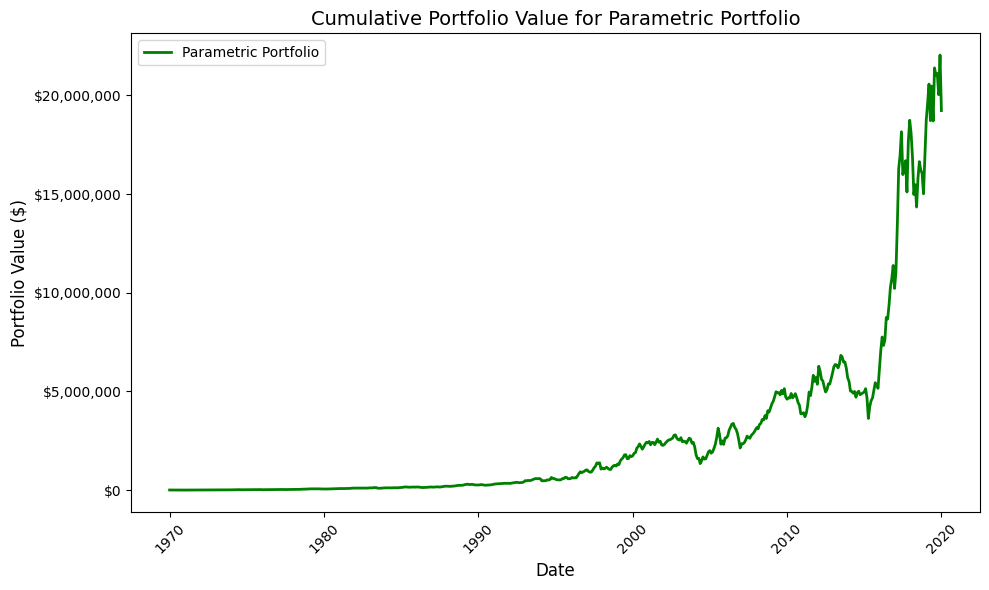

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker

# Initial portfolio value
initial_portfolio_value = 10000

# Calculate cumulative return for the Parametric Portfolio (out_sample_results)
parametric_portfolio_value = [initial_portfolio_value]
for i in range(1, len(out_sample_results)):
    portfolio_return = out_sample_results['portfolio_return'].iloc[i] / 100  # Convert percentage returns to decimals
    new_portfolio_value = parametric_portfolio_value[-1] * (1 + portfolio_return)
    parametric_portfolio_value.append(new_portfolio_value)

# Convert parametric portfolio value list into a pandas series
parametric_portfolio_value_series = pd.Series(parametric_portfolio_value, index=out_sample_results.index)

# Plot the Parametric Portfolio cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(parametric_portfolio_value_series.index, parametric_portfolio_value_series, label='Parametric Portfolio', color='green', linewidth=2)
plt.title('Cumulative Portfolio Value for Parametric Portfolio', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend()

# Manually set x-ticks for every decade
tick_positions = np.linspace(0, len(parametric_portfolio_value_series) - 1, num=6, dtype=int)  # Calculate positions dynamically for 6 labels
tick_labels = [str(year) for year in range(1970, 2024, 10)]  # Adjust required range

#set x y labels and ticks
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'${x:,.0f}'))

plt.tight_layout()
plt.show()
